### Applied Machine Learning Midterm Project
### Nick Elias

* CSIS 44670-81
* Date: 4/18/2025

### Overview

- Businesses and organizations often need to understand the relationships between different factors to make better decisions.  
    - For example, a company may want to predict the fuel efficiency of a car based on its weight and engine size or estimate home prices based on square footage and location.  
- Regression analysis helps identify and quantify these relationships between numerical features, providing insights that can be used for forecasting and decision-making.  

This project demonstrates your ability to apply regression modeling techniques to a real-world dataset. You will:  
- Load and explore a dataset.  
- Choose and justify features for predicting a target variable.  
- Train a regression model and evaluate performance.  
- Compare multiple regression approaches.  
- Document your work in a structured Jupyter Notebook.  
- Conduct a peer review of a classmate's project.  

# Introduction

In [42]:
# Standard libraries
import os
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-learn: Model selection
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve

# Scikit-learn: Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree


# Scikit-learn: Metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

from itertools import combinations

# Custom preprocessing pipeline
from preprocessing_pipeline import preprocess_data, pipeline

Section 1. Import and Inspect the Data
1.1 Load the dataset and display the first 10 rows.
1.2 Check for missing values and display summary statistics.
Reflection 1: What do you notice about the dataset? Are there any data issues?

In [ ]:
# Load the dataset
data = pd.read_csv('data/train.csv')

# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)

# Display the first 10 rows
print("First 10 rows of the dataset:")
print(data.head(10))

In [ ]:
# Ensure all columns are displayed without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Adjusts the width to avoid wrapping
pd.set_option('display.max_colwidth', None)  # Ensures full content of each column is shown

# Display column names and their data types
print("Column names and their data types:")
print(data.dtypes)

In [ ]:
# Display columns with missing data
missing_data = data.isnull().sum()
missing_columns = missing_data[missing_data > 0]
print("Columns with missing data:")
print(missing_columns)

In [ ]:
# Display summary statistics
print("\nSummary statistics of the dataset:")
print(data.describe())

### **Dataset Observations:**

The dataset contains real estate data related to housing prices.

*General Structure:*

- The dataset contains a mix of numerical and categorical columns.
- The target variable seems to be SalePrice, which represents the price of a house.

*Columns with Missing Data:*

- Some columns, such as Alley, FireplaceQu, PoolQC, Fence, and MiscFeature, have missing values (NaN).
- These columns may require imputation or removal depending on their importance.

*Features:*

- Numerical Features: Examples include LotFrontage, LotArea, YearBuilt, GrLivArea, and SalePrice.
- Categorical Features: Examples include MSZoning, Street, LotShape, and Neighborhood.

*Potential Relationships:*

- Features like GrLivArea, OverallQual, and YearBuilt might have a strong correlation with SalePrice.
- Categorical features like Neighborhood and MSZoning could also influence housing prices.

*Outliers and Anomalies:*

- Some columns, such as LotFrontage, have missing values in certain rows.
- Columns like GarageYrBlt have numerical values but may need special handling for missing data.

*Target Variable:*

- SalePrice is the target variable for regression analysis.

---

## Section 2. Data Exploration and Preparation
### 2.1 Explore data patterns and distributions
- Create histograms, boxplots, and count plots for categorical variables (as applicable).
- Identify patterns, outliers, and anomalies in feature distributions.
- Check for class imbalance in the target variable (as applicable).

In [ ]:
# Define the mapping for MSSubClass
mssubclass_mapping = {
    20: "1-STORY 1946 & NEWER",
    30: "1-STORY 1945 & OLDER",
    40: "1-STORY W/FINISHED ATTIC",
    45: "1-1/2 STORY - UNFINISHED",
    50: "1-1/2 STORY FINISHED",
    60: "2-STORY 1946 & NEWER",
    70: "2-STORY 1945 & OLDER",
    75: "2-1/2 STORY ALL AGES",
    80: "SPLIT OR MULTI-LEVEL",
    85: "SPLIT FOYER",
    90: "DUPLEX - ALL STYLES",
    120: "1-STORY PUD 1946 & NEWER",
    150: "1-1/2 STORY PUD",
    160: "2-STORY PUD 1946 & NEWER",
    180: "PUD - MULTILEVEL",
    190: "2 FAMILY CONVERSION"
}

# Apply the mapping to the MSSubClass column
data['MSSubClassMapped'] = data['MSSubClass'].map(mssubclass_mapping)

# Display unique values in MSSubClass and their mapped names
print("Unique values in MSSubClass:")
print(data['MSSubClass'].unique())

print("\nUnique mapped values in MSSubClassMapped:")
print(data['MSSubClassMapped'].unique())

In [ ]:
# Scatterplots for numerical variables
numerical_vars = ['GrLivArea', 'YearBuilt']
for var in numerical_vars:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=var, y='SalePrice', data=data)
    plt.title(f'{var} vs SalePrice')
    plt.xlabel(var)
    plt.ylabel('SalePrice')
    plt.grid(alpha=0.3)
    plt.show()

In [ ]:
# Boxplots for categorical variables
categorical_vars = ['MSSubClassMapped', 'Neighborhood', 'GarageType','OverallQual']
for var in categorical_vars:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=var, y='SalePrice', data=data)
    plt.title(f'{var} vs SalePrice')
    plt.xlabel(var)
    plt.ylabel('SalePrice')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

### *Patterns, outliers, and anomalies*

### Observations on Variables

**'GrLivArea'**
- **Pattern:** Positive linear relationship with `SalePrice`.
- **Outliers:**
    - Only 4 listings exceed 4000 sqft.
    - The largest listing (over 4000 sqft) is surprisingly cheap, priced under $200k.
- **Anomalies:** None identified.

**'OverallQual'**
- **Pattern:** Positive linear relationship; better quality correlates with higher `SalePrice`.
- **Outliers:**
    - Quality score 4 has one outlier priced about $75k higher than other listings.
- **Anomalies:** Higher quality scores exhibit greater variance. A box plot may help visualize this.

**'YearBuilt'**
- **Pattern:** No obvious correlation with `SalePrice`.
- **Outliers:**
    - A house built around 1890 is over $100k more expensive than the next most expensive.
    - Some houses built in the 1990s are at least $200k more expensive than the next.
- **Anomalies:** Unclear.

**'MSSubClass'**
- **Pattern:**
    - "2-Story 1946 & Newer" has the highest maximum price and average price but also many outliers.
    - "1-Story PUD 1946 & Newer" has the lowest average and minimum prices.
    - Median distributions show little variance, suggesting it may not be a strong predictor.
- **Outliers:**
    - "2-Story 1946 & Newer" and "1-Story 1946 & Newer" have outliers above the plot.
- **Anomalies:** Unclear.

**'Neighborhood'**
- **Pattern:** Significant variance in median `SalePrice`, indicating it might be a strong predictor.
- **Outliers:**
    - "NoRidge" has an average around $300k but outliers peak over $700k.
- **Anomalies:** Unclear.

**'GarageType'**
- **Pattern:** Some variance in median `SalePrice` across categories.
- **Outliers:**
    - "Attachd" has many outliers above the plot.
- **Anomalies:** Unclear.


#### Class Inbalance Check
First, checking the distribution of Target Variable SalePrice

Then, checking distibution of 6 chosen attributes. Optional, but will benefit analysis

In [ ]:
# Plot a histogram for the target variable
data['SalePrice'].hist(bins=20, figsize=(8, 6))
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

- The distribution of SalePrice is right-skewed (positively skewed), meaning most of the house prices are concentrated in the lower range (e.g., below $200,000), while fewer houses are in the higher price ranges.

- There is a long tail extending toward higher prices, indicating a small number of expensive houses.

- Models might struggle to predict higher-priced houses accurately because they are underrepresented in the data.

In [ ]:
# OPTIONAL: Check class distribution for categorical variables
categorical_vars = ['MSSubClassMapped', 'Neighborhood', 'GarageType']
for var in categorical_vars:
    print(f"Class distribution for {var}:")
    print(data[var].value_counts(normalize=True) * 100)  # Display percentages
    print("\n")

In [ ]:
# OPTIONAL: Plot histograms for numerical variables
#numerical_vars = ['GrLivArea', 'OverallQual', 'YearBuilt']
#for var in numerical_vars:
#    data[var].hist(bins=20, figsize=(8, 6))
#    plt.title(f"Distribution of {var}")
#    plt.xlabel(var)
#    plt.ylabel("Frequency")
#    plt.grid(alpha=0.3)
#    plt.show()

### 2.2 Handle missing values and clean data
- Impute or drop missing values (as applicable).
- Remove or transform outliers (as applicable).
- Convert categorical data to numerical format using encoding (as applicable).

In [ ]:
# List of 6 interesting variables
chosen_vars = ['GrLivArea', 'OverallQual', 'YearBuilt', 'MSSubClassMapped', 'Neighborhood', 'GarageType']

# Check for missing values in the chosen variables
missing_values = data[chosen_vars].isnull().sum()

# Calculate the percentage of missing values
total_records = len(data)
missing_percentage = (missing_values / total_records) * 100

# Combine the counts and percentages into a DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

# Display the result
print("Missing values in the chosen variables:")
print(missing_summary)

There are clear visual outliers in the target variable (houses over $500k) and in the GrLivArea variable (values over 4000). Before we make changes, let's see how many records would be impacted:

In [ ]:
# Total number of records in the dataset
total_records = len(data)

# Count values where SalePrice > 500k
saleprice_above_500k = data[data['SalePrice'] > 500000]
count_saleprice_above_500k = len(saleprice_above_500k)
percentage_saleprice_above_500k = (count_saleprice_above_500k / total_records) * 100

# Count values where GrLivArea > 4000
grlivarea_above_4000 = data[data['GrLivArea'] > 4000]
count_grlivarea_above_4000 = len(grlivarea_above_4000)
percentage_grlivarea_above_4000 = (count_grlivarea_above_4000 / total_records) * 100

# Print results
print(f"Number of houses with SalePrice > 500k: {count_saleprice_above_500k} ({percentage_saleprice_above_500k:.2f}%)")
print(f"Number of houses with GrLivArea > 4000: {count_grlivarea_above_4000} ({percentage_grlivarea_above_4000:.2f}%)")

These outlier records represent a very small portion of the total data. Let's remove them to reduce skew.

In [ ]:
# Remove outliers where SalePrice > 500k or GrLivArea > 4000
data_cleaned = data[(data['SalePrice'] <= 500000) & (data['GrLivArea'] <= 4000)]

# Calculate the number of records removed
records_removed = len(data) - len(data_cleaned)

# Print the results
print(f"Original dataset size: {len(data)}")
print(f"Cleaned dataset size: {len(data_cleaned)}")
print(f"Number of records removed: {records_removed}")

### 2.3 Feature selection and engineering
- Create new features (as applicable).
- Transform or combine existing features to improve model performance (as applicable).
- Scale or normalize data (as applicable).

In [ ]:
# Create the HouseAge feature using .loc
data_cleaned.loc[:, 'HouseAge'] = 2025 - data_cleaned['YearBuilt']

# Display the first few rows to verify
print(data_cleaned[['YearBuilt', 'HouseAge']].head())

# Scatterplot of HouseAge vs SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='HouseAge', y='SalePrice', data=data_cleaned, color='blue', alpha=0.6)
plt.title("HouseAge vs SalePrice", fontsize=16)
plt.xlabel("HouseAge (years)", fontsize=12)
plt.ylabel("SalePrice", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Visualize the distribution of the HouseAge variable
plt.figure(figsize=(8, 6))
data_cleaned['HouseAge'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of HouseAge", fontsize=16)
plt.xlabel("HouseAge (years)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Define numerical and categorical features
numerical_features = ['GrLivArea', 'HouseAge']
categorical_features_onehot = ['Neighborhood']  # Use OneHotEncoding for these
categorical_features_ordinal = ['OverallQual', 'MSSubClassMapped']  # Use OrdinalEncoding for these

# Define transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output=False, drop='first')
ordinal = OrdinalEncoder()

# Combine transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),  # Scale numerical features
        ('onehot', ohe, categorical_features_onehot),  # OneHotEncode selected categorical features
        ('ordinal', ordinal, categorical_features_ordinal)  # OrdinalEncode selected categorical features
    ]
)

# Apply transformations
data_transformed = preprocessor.fit_transform(data_cleaned)

# Get feature names for the transformed data
numerical_feature_names = numerical_features
onehot_feature_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features_onehot)
ordinal_feature_names = categorical_features_ordinal
all_feature_names = list(numerical_feature_names) + list(onehot_feature_names) + list(ordinal_feature_names)

# Convert the transformed data back to a DataFrame
data_transformed_df = pd.DataFrame(data_transformed, columns=all_feature_names, index=data_cleaned.index)

# Display the first few rows of the transformed data
print(data_transformed_df.head())

### Reflection 2: What patterns or anomalies do you see? Do any features stand out? What preprocessing steps were necessary to clean and improve the data? Did you create or modify any features to improve performance?

Outliers were removed in the following variables:

- GrLivArea: records > 4000 sqft were priced significantly lower than expected, so they were removed.
- SalePrice (target variable): records > $500k were found to be outliers and removed from analysis.

Features that stands out: 

- OverallQual has what appears to be a strong positive correlation with SalePrice; higher quality scores generally correspond to higher prices.
- Neighborhood has significant variance in median SalePrice, suggesting it might be a strong categorical predictor as well

Preprocessing steps:

- Created HouseAge to replace YearBuilt. See explanation in following cell.
- Encoded categorical variables for compatibility with machine learning models.
- Used StandardScaler to standardize numerical features for better fit with machine learning models.

### *Why Create HouseAge Instead of Using YearBuilt?*
Creating HouseAge has several advantages over directly using YearBuilt:

- Interpretability:

    - HouseAge is easier to interpret because it directly represents how old a house is, which is often more meaningful than the year it was built.

- Linear Relationships:

    - HouseAge may have a more linear relationship with the target variable (SalePrice) compared to YearBuilt, which is often non-linear.

- Temporal Relevance:

    - YearBuilt is tied to a specific calendar year, which may lose relevance over time. HouseAge dynamically adjusts as the current year changes, making it more robust for future predictions.

- Feature Scaling:

    - YearBuilt has a large range (e.g., 1800–2025), which can make it harder to scale or normalize. HouseAge typically has a smaller range (e.g., 0–200), making it easier to work with.

---

## Section 3. Feature Selection and Justification
### 3.1 Choose features and target
- Select two or more input features (numerical for regression, numerical and/or categorical for classification)
- Select a target variable (as applicable)
- Regression: Continuous target variable (e.g., price, temperature).
- Classification: Categorical target variable (e.g., gender, species).
- Clustering: No target variable.
- Justify your selection with reasoning.


In [ ]:
##############################################################################################
# Define Target and Input Features for Regression Analysis
##############################################################################################

# Target feature
target_feature = 'SalePrice'  # Numerical (continuous)

# Input features
input_features = {
    'GrLivArea': 'Numerical',
    'HouseAge': 'Numerical',
    'OverallQual': 'Categorical (Ordinal)',
    'MSSubClassMapped': 'Categorical (Ordinal)',
    'Neighborhood': 'Categorical (Nominal)'
}

# Display the target and input features
print("### Regression Analysis ###")
print(f"Target Feature: {target_feature} (Numerical - Continuous)")
print("\nInput Features:")
for feature, feature_type in input_features.items():
    print(f"- {feature}: {feature_type}")

### 3.2 Define X and y
- Assign input features to X
- Assign target variable to y (as applicable)


In [ ]:
# Define the target variable (y) for Linear Regression
y_linear = data_cleaned['SalePrice']

# Define the input features (X) for Linear Regression
X_linear = data_cleaned[['GrLivArea', 'HouseAge', 'OverallQual', 'MSSubClassMapped', 'Neighborhood']]

# Display the shapes of X and y to confirm
print(f"Shape of X_linear: {X_linear.shape}")
print(f"Shape of y_linear: {y_linear.shape}")

### Reflection 3: Why did you choose these features? How might they impact predictions or accuracy?

### Justification for Regression and Feature Selection

The target variable, `SalePrice`, was chosen as it represents the continuous outcome we aim to predict, making this a regression problem. The input features were selected based on their potential correlation with `SalePrice`:

- **GrLivArea** and **HouseAge** are numerical features likely to have a direct impact on housing prices (e.g., larger houses or newer houses may be more expensive).
- **OverallQual** and **MSSubClassMapped** are ordinal categorical features that capture quality and property type, which are strong indicators of value.
- **Neighborhood** is a nominal categorical feature that reflects location, a critical factor in real estate pricing.

These features were chosen to balance interpretability and predictive power for the regression analysis.

---

## Section 4. Train a Model (Linear Regression)
### 4.1 Split the data into training and test sets using train_test_split (or StratifiedShuffleSplit if class imbalance is an issue).
### 4.2 Train model using Scikit-Learn model.fit() method
### 4.3 Evalulate performance, for example:
- Regression: R^2, MAE, RMSE (RMSE has been recently updated)
- Classification: Accuracy, Precision, Recall, F1-score, Confusion Matrix
- Clustering: Inertia, Silhouette Score

In [ ]:
# Store results for comparison
results = []

# Iterate through each feature in input_features
for feature in input_features.keys():
    print(f"Testing with feature: {feature}")
    
    # Define X and y
    X_single = data_cleaned[[feature]]  # Use the current feature as input
    y = data_cleaned['SalePrice']      # Target variable
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_single, y, test_size=0.2, random_state=42)
    
    # Train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)
    
    # Evaluate the model's performance
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    # Store results
    results.append({
        'Feature': feature,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })
    
    # Print the evaluation metrics
    print(f"Feature: {feature}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    print("-" * 50)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)

In [ ]:
# Store results for comparison
results = []

# Get the list of feature names from input_features
feature_names = list(input_features.keys())

# Generate all possible combinations of features
for r in range(1, len(feature_names) + 1):  # r is the number of features in the combination
    for combination in combinations(feature_names, r):
        # Define X and y
        X_combination = data_cleaned[list(combination)]  # Use the current combination of features
        y = data_cleaned['SalePrice']  # Target variable
        
        # Split the data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_combination, y, test_size=0.2, random_state=42)
        
        # Train the Linear Regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Make predictions on the validation set
        y_val_pred = model.predict(X_val)
        
        # Evaluate the model's performance
        mse = mean_squared_error(y_val, y_val_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val, y_val_pred)
        r2 = r2_score(y_val, y_val_pred)
        
        # Store results
        results.append({
            'Features': combination,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Ensure R2 column is numeric
results_df['R2'] = pd.to_numeric(results_df['R2'], errors='coerce')

# Sort results by R² score in descending order
results_df = results_df.sort_values(by='R2', ascending=False)

# Save all results to a CSV file
results_df.to_csv('feature_combinations_results.csv', index=False)

# Display the top 3 results
print("Top 3 feature combinations:")
print(results_df.head(3))

### Performance Validation: Predicted Values vs. Actual Values

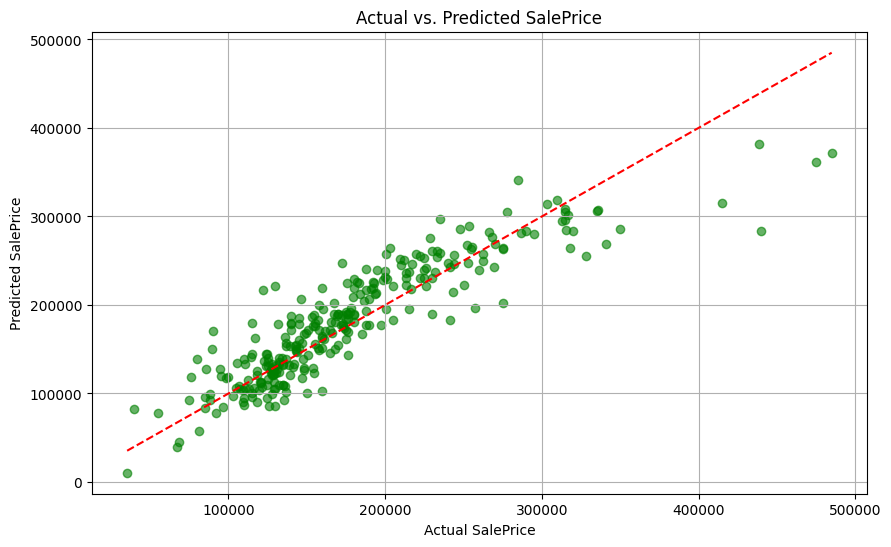

In [46]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
plt.title('Actual vs. Predicted SalePrice')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.grid()
plt.show()

### Cross-Validation to further check model performance

In [41]:
# Evaluate the model's performance
# Perform cross-validation
cv_scores = cross_val_score(model, X_combination, y, cv=5, scoring='r2')  # 5-fold cross-validation
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R² Score: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation of R² Scores: {np.std(cv_scores):.2f}")

Cross-Validation R² Scores: [0.80076329 0.81180668 0.78324767 0.7854491  0.75215136]
Mean R² Score: 0.79
Standard Deviation of R² Scores: 0.02


### Learning Curve Analysis to further check model performance

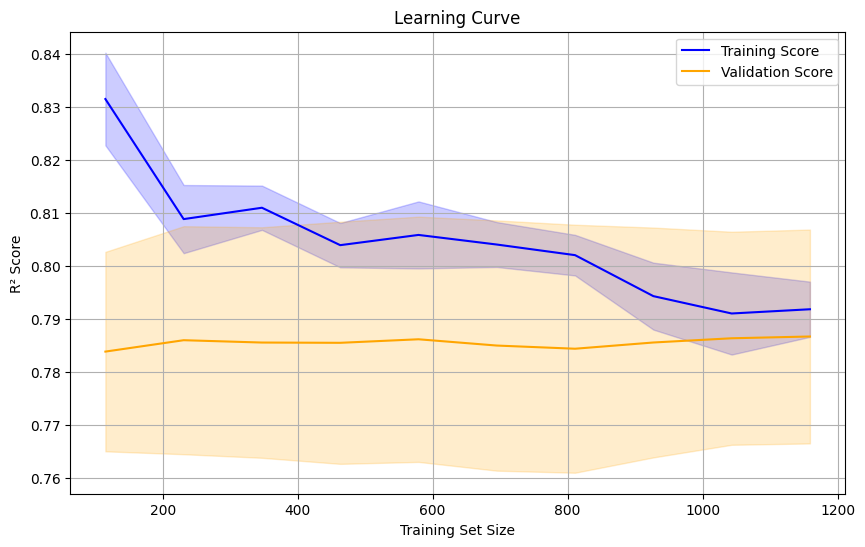

In [43]:
# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    model, X_combination, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, label='Validation Score', color='orange')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.legend()
plt.grid()
plt.show()

### Final Check: Correlation Matrix to check for Multicollinearity

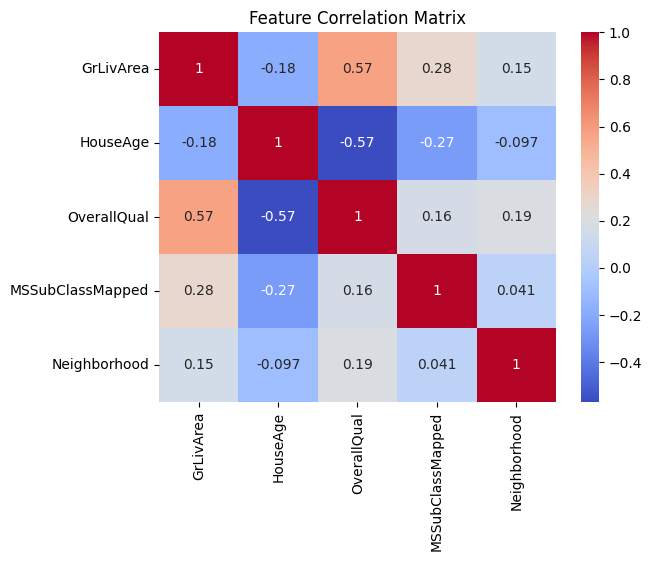

In [45]:
# Compute correlation matrix
correlation_matrix = data_cleaned[['GrLivArea', 'HouseAge', 'OverallQual', 'MSSubClassMapped', 'Neighborhood']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

### Reflection 4: How well did the model perform? Any surprises in the results?

## Section 5. Improve the Model or Try Alternates (Implement Pipelines)
### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression.


### 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression.


### 5.3 Compare performance of all models across the same performance metrics


### Reflection 5: Which models performed better? How does scaling impact results?

## Section 6. Final Thoughts & Insights
### 6.1 Summarize findings.


### 6.2 Discuss challenges faced.


### 6.3 If you had more time, what would you try next?


### Reflection 6: What did you learn from this project?